In [ ]:
!pip install matplotlib laspy
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zl5sbm_9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zl5sbm_9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2024-04-17 16:20:10--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.1’

dog

In [ ]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import laspy
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

In [ ]:
def sam_masks(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))
        c_mask.append(img)
    return c_mask

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def cloud_to_image(pcd_np, resolution):
    minx = np.min(pcd_np[:, 0])
    maxx = np.max(pcd_np[:, 0])
    miny = np.min(pcd_np[:, 1])
    maxy = np.max(pcd_np[:, 1])
    width = int((maxx - minx) / resolution) + 1
    height = int((maxy - miny) / resolution) + 1
    image = np.zeros((height, width, 3), dtype=np.uint8)
    for point in pcd_np:
        x, y, *_ = point
        r, g, b = point[-3:]
        pixel_x = int((x - minx) / resolution)
        pixel_y = int((maxy - y) / resolution)
        image[pixel_y, pixel_x] = [r, g, b]
    return image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Data_3D/DATA/"
import os
os.listdir(data_path)

['34FN2_18.las',
 'ITC_BUILDING.las',
 'biscarosse.jpg',
 'biscarosse_c.jpg',
 'ITC_BUILDING_spherical_projection.jpg',
 '34FN2_18_orthoimage.jpg']

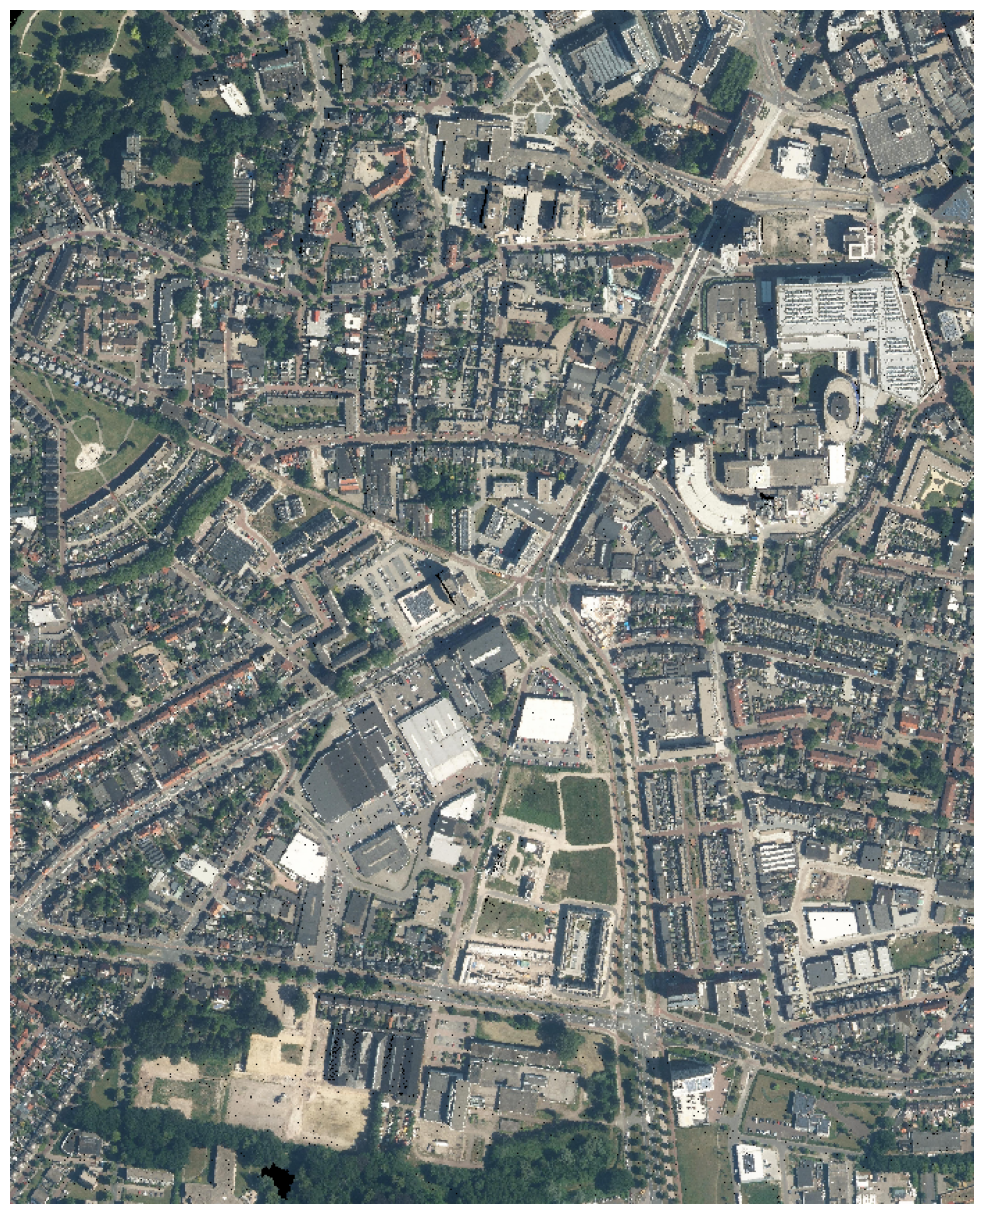

In [ ]:
#Reading the point cloud with laspy
pcd = laspy.read(os.path.join(data_path, "34FN2_18.las"))

#Transforming the point cloud to Numpy
pcd_np = np.vstack((pcd.x, pcd.y, pcd.z, (pcd.red/65535*255).astype(int), (pcd.green/65535*255).astype(int), (pcd.blue/65535*255).astype(int))).transpose()

#Ortho-Projection
orthoimage = cloud_to_image(pcd_np, 1.5)

#Plotting and exporting
fig = plt.figure(figsize=(np.shape(orthoimage)[1]/72, np.shape(orthoimage)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(orthoimage)
plt.axis('off')
plt.savefig("34FN2_18_orthoimage.jpg")

In [ ]:
def generate_spherical_image(center_coordinates, point_cloud, colors, resolution_y=500):
    # Translate the point cloud by the negation of the center coordinates
    translated_points = point_cloud - center_coordinates

    # Convert 3D point cloud to spherical coordinates
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
    phi = np.arccos(translated_points[:, 2] / np.linalg.norm(translated_points, axis=1))

    # Map spherical coordinates to pixel coordinates
    x = (theta + np.pi) / (2 * np.pi) * (2 * resolution_y)
    y = phi / np.pi * resolution_y

     # Create the spherical image with RGB channels
    resolution_x = 2 * resolution_y
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)

    # Create the mapping between point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)

    # Assign points to the image pixels
    for i in range(len(translated_points)):
        ix = np.clip(int(x[i]), 0, resolution_x - 1)
        iy = np.clip(int(y[i]), 0, resolution_y - 1)
        if mapping[iy, ix] == -1 or np.linalg.norm(translated_points[i]) < np.linalg.norm(translated_points[mapping[iy, ix]]):
            mapping[iy, ix] = i
            image[iy, ix] = colors[i]
    return image, mapping

In [ ]:
#Loading the las file from the disk
las = laspy.read(os.path.join(data_path,"ITC_BUILDING.las"))

#Transforming to a numpy array
coords = np.vstack((las.x, las.y, las.z))
point_cloud = coords.transpose()

#Gathering the colors
r=(las.red/65535*255).astype(int)
g=(las.green/65535*255).astype(int)
b=(las.blue/65535*255).astype(int)
colors = np.vstack((r,g,b)).transpose()

In [ ]:
resolution = 500

#Defining the position in the point cloud to generate a panorama
center_coordinates = [189, 60, 2]

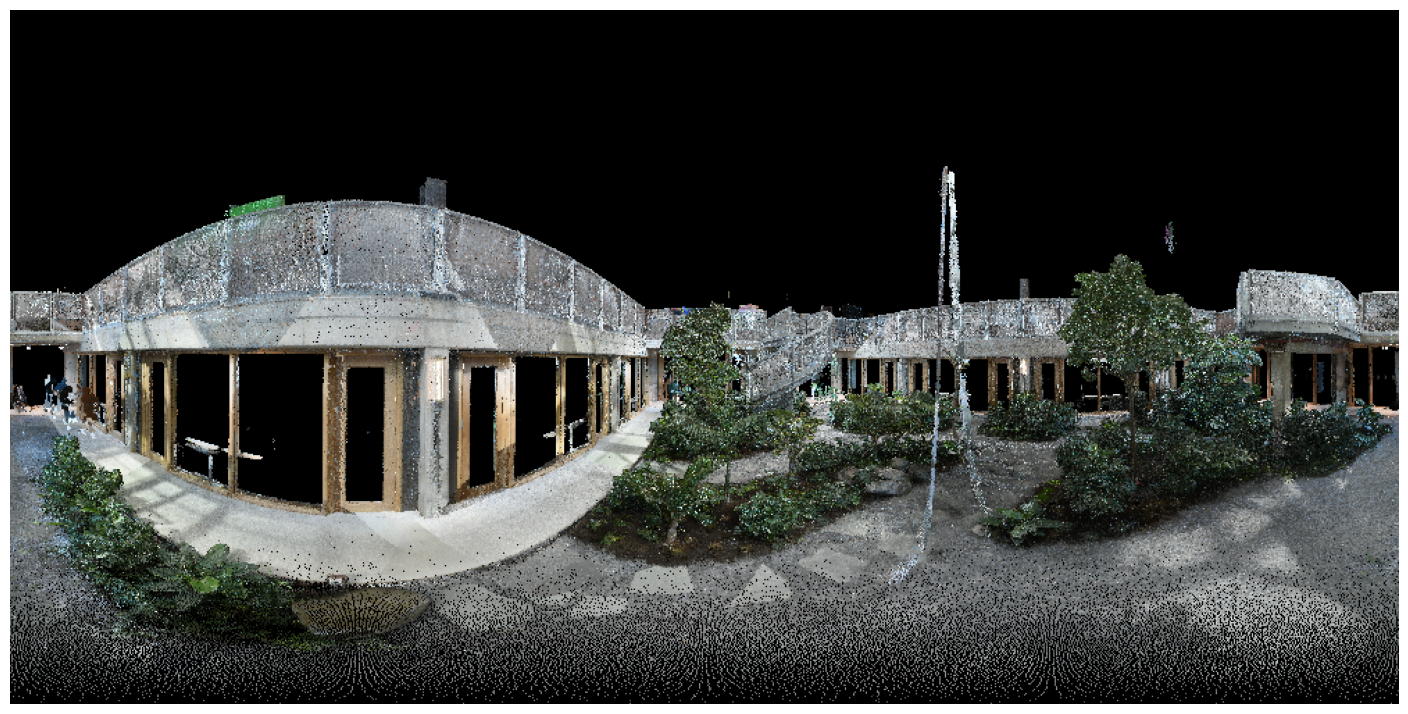

In [ ]:
#Function Execution
spherical_image, mapping = generate_spherical_image(center_coordinates, point_cloud, colors, resolution)

#Plotting with matplotlib
fig = plt.figure(figsize=(np.shape(spherical_image)[1]/72, np.shape(spherical_image)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(spherical_image)
plt.axis('off')

#Saving to the disk
plt.savefig("ITC_BUILDING_spherical_projection.jpg")

In [ ]:
import time
temp_img = cv2.imread("ITC_BUILDING_spherical_projection.jpg")
image_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

t0 = time.time()
result = mask_generator.generate(image_rgb)
t1 = time.time()

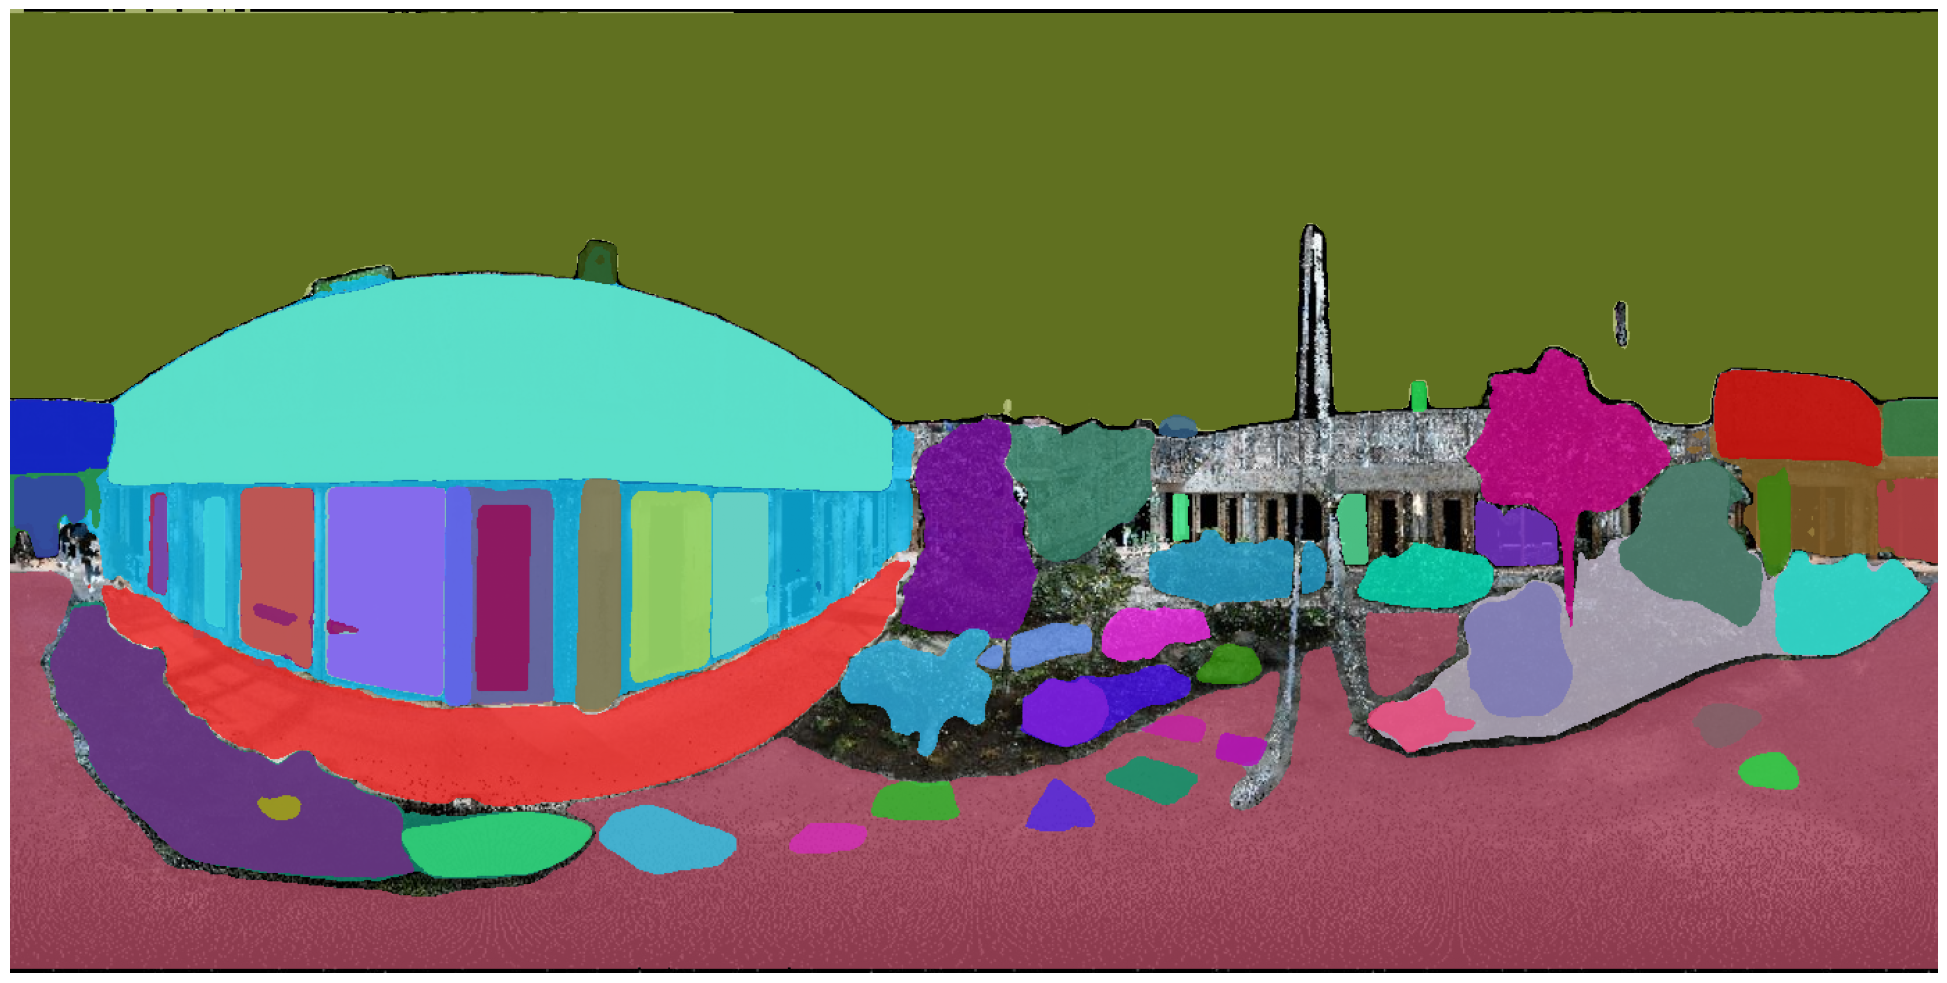

In [ ]:
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("ITC_BUILDING_spherical_projection_segmented.jpg")

In [ ]:
def color_point_cloud(image_path, point_cloud, mapping):
    #Resize image and flip x/y to match mapping
    shape = (mapping.shape[1], mapping.shape[0])
    image = cv2.resize(cv2.imread(image_path), shape)
    h, w = image.shape[:2]
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1]+3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                color = image[iy, ix]
                modified_point_cloud[point_index, 3:] = color
    return modified_point_cloud

In [ ]:
modified_point_cloud = color_point_cloud("ITC_BUILDING_spherical_projection_segmented.jpg", point_cloud, mapping)

In [ ]:
def export_point_cloud(cloud_path, modified_point_cloud):
    # 1. Create a new header
    header = laspy.LasHeader(point_format=3, version="1.2")
    header.add_extra_dim(laspy.ExtraBytesParams(name="random", type=np.int32))

    # 2. Create a Las
    las_o = laspy.LasData(header)
    las_o.x = modified_point_cloud[:,0]
    las_o.y = modified_point_cloud[:,1]
    las_o.z = modified_point_cloud[:,2]
    las_o.red = modified_point_cloud[:,3]
    las_o.green = modified_point_cloud[:,4]
    las_o.blue = modified_point_cloud[:,5]
    las_o.write(cloud_path)

    print("Export succesful at: ", cloud_path)
    return


In [ ]:
export_point_cloud("pcd_results.las", modified_point_cloud)

Export succesful at:  pcd_results.las


In [ ]:
!pip install open3d
import open3d as o3d
#Loading the las file from the disk
las = laspy.read(os.path.join(data_path,"ITC_BUILDING.las"))

#Transforming to a numpy array
coords = np.vstack((las.x, las.y, las.z))
point_cloud = coords.transpose()


#Gathering the colors
r=(las.red/65535*255).astype(int)
g=(las.green/65535*255).astype(int)
b=(las.blue/65535*255).astype(int)
colors = np.vstack((r,g,b)).transpose()


 # Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)

# Save to PLY
o3d.io.write_point_cloud("hihi.ply", pcd)